# Spark MLLib Example: Clustering

Let's look at a clustering example in Spark MLLib.

Here, we are going to load the mtcars dataset. This has some stats on different models of cars.  Here, we will load the CSV file as a spark dataframe, and view it.

This dataset contains some statistics on 1974 Cars from Motor Trends

Here are the columns:
* name   - name of the car
*  mpg   - Miles/(US) gallon                        
*  cyl   - Number of cylinders                      
*  disp  - Displacement (cu.in.)                    
*  hp    - Gross horsepower                         
*  drat  - Rear axle ratio            

Are there any natural clusters you can identify from this data?

We are going to use **MPG and CYL** attributes to cluster.

You can also download and view the raw data in Excel : [cars.csv](/data/cars/mtcars_header.csv)

<img src="../../assets/images/6.1-cars2.png" style="border: 5px solid grey; max-width:100%;" />

In [1]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
sc = spark.sparkContext

Initializing Spark...
Spark found in :  /home/ubuntu/apps/spark
Spark config:
	 spark.app.name=TestApp
	spark.master=local[*]
	executor.memory=2g
	spark.sql.warehouse.dir=/tmp/tmpyszsvhhy
	some_property=some_value
Spark UI running on port 4041


## Step 1 : Load Data

In [2]:
import os
import urllib.request

data_location = "../data/cars/mtcars_header.csv"
data_url = 'https://elephantscale-public.s3.amazonaws.com/data/cars/mtcars_header.csv'
if not os.path.exists (data_location):
    data_location = 'mtcars_header.csv'
    if not os.path.exists(data_location):
        print("Downloading : ", data_url)
        urllib.request.urlretrieve(data_url, data_location)
print('data_location:', data_location)

data_location: mtcars_header.csv


In [3]:
dataset = spark.read.csv (data_location, header=True, inferSchema=True)

In [4]:
## TODO : print schema
## Hint : printSchema()
dataset.printSchema()

root
 |-- model: string (nullable = true)
 |-- mpg: double (nullable = true)
 |-- cyl: integer (nullable = true)
 |-- disp: double (nullable = true)
 |-- hp: integer (nullable = true)
 |-- drat: double (nullable = true)
 |-- wt: double (nullable = true)
 |-- qsec: double (nullable = true)
 |-- vs: integer (nullable = true)
 |-- am: integer (nullable = true)
 |-- gear: integer (nullable = true)
 |-- carb: integer (nullable = true)



In [5]:
## TODO : display the data
## Hint : show
dataset.show()

+-------------------+----+---+-----+---+----+-----+-----+---+---+----+----+
|              model| mpg|cyl| disp| hp|drat|   wt| qsec| vs| am|gear|carb|
+-------------------+----+---+-----+---+----+-----+-----+---+---+----+----+
|          Mazda RX4|21.0|  6|160.0|110| 3.9| 2.62|16.46|  0|  1|   4|   4|
|      Mazda RX4 Wag|21.0|  6|160.0|110| 3.9|2.875|17.02|  0|  1|   4|   4|
|         Datsun 710|22.8|  4|108.0| 93|3.85| 2.32|18.61|  1|  1|   4|   1|
|     Hornet 4 Drive|21.4|  6|258.0|110|3.08|3.215|19.44|  1|  0|   3|   1|
|  Hornet Sportabout|18.7|  8|360.0|175|3.15| 3.44|17.02|  0|  0|   3|   2|
|            Valiant|18.1|  6|225.0|105|2.76| 3.46|20.22|  1|  0|   3|   1|
|         Duster 360|14.3|  8|360.0|245|3.21| 3.57|15.84|  0|  0|   3|   4|
|          Merc 240D|24.4|  4|146.7| 62|3.69| 3.19| 20.0|  1|  0|   4|   2|
|           Merc 230|22.8|  4|140.8| 95|3.92| 3.15| 22.9|  1|  0|   4|   2|
|           Merc 280|19.2|  6|167.6|123|3.92| 3.44| 18.3|  1|  0|   4|   4|
|          M

## Step 2 : Extract data
We only care about 'model', 'mpg' and 'cyl' columns

In [6]:
## TODO : extract the columns we need : model, mpg and cyl
dataset2 = dataset.select(["model", "mpg", "cyl"])
dataset2.show()

+-------------------+----+---+
|              model| mpg|cyl|
+-------------------+----+---+
|          Mazda RX4|21.0|  6|
|      Mazda RX4 Wag|21.0|  6|
|         Datsun 710|22.8|  4|
|     Hornet 4 Drive|21.4|  6|
|  Hornet Sportabout|18.7|  8|
|            Valiant|18.1|  6|
|         Duster 360|14.3|  8|
|          Merc 240D|24.4|  4|
|           Merc 230|22.8|  4|
|           Merc 280|19.2|  6|
|          Merc 280C|17.8|  6|
|         Merc 450SE|16.4|  8|
|         Merc 450SL|17.3|  8|
|        Merc 450SLC|15.2|  8|
| Cadillac Fleetwood|10.4|  8|
|Lincoln Continental|10.4|  8|
|  Chrysler Imperial|14.7|  8|
|           Fiat 128|32.4|  4|
|        Honda Civic|30.4|  4|
|     Toyota Corolla|33.9|  4|
+-------------------+----+---+
only showing top 20 rows



## Step 3 : Creating Vectors

Now that we have ourselves a dataframe, let's work on turning it into vectors.  We're going to vectorize 2 columns:

1. MPG
2. Number of cylinders.

What we'll do, is we'll use the VectorAssembler class to create a new column by the name of features. This will be a Vector.

In [7]:
from pyspark.ml.feature import VectorAssembler

## TODO : create featureVector with 'mpg' and 'cyl'
## Hint :  inputCols=['mpg', 'cyl']
assembler = VectorAssembler(inputCols=["mpg", "cyl"], outputCol="features")
featureVector = assembler.transform(dataset2)
featureVector.show()

+-------------------+----+---+----------+
|              model| mpg|cyl|  features|
+-------------------+----+---+----------+
|          Mazda RX4|21.0|  6|[21.0,6.0]|
|      Mazda RX4 Wag|21.0|  6|[21.0,6.0]|
|         Datsun 710|22.8|  4|[22.8,4.0]|
|     Hornet 4 Drive|21.4|  6|[21.4,6.0]|
|  Hornet Sportabout|18.7|  8|[18.7,8.0]|
|            Valiant|18.1|  6|[18.1,6.0]|
|         Duster 360|14.3|  8|[14.3,8.0]|
|          Merc 240D|24.4|  4|[24.4,4.0]|
|           Merc 230|22.8|  4|[22.8,4.0]|
|           Merc 280|19.2|  6|[19.2,6.0]|
|          Merc 280C|17.8|  6|[17.8,6.0]|
|         Merc 450SE|16.4|  8|[16.4,8.0]|
|         Merc 450SL|17.3|  8|[17.3,8.0]|
|        Merc 450SLC|15.2|  8|[15.2,8.0]|
| Cadillac Fleetwood|10.4|  8|[10.4,8.0]|
|Lincoln Continental|10.4|  8|[10.4,8.0]|
|  Chrysler Imperial|14.7|  8|[14.7,8.0]|
|           Fiat 128|32.4|  4|[32.4,4.0]|
|        Honda Civic|30.4|  4|[30.4,4.0]|
|     Toyota Corolla|33.9|  4|[33.9,4.0]|
+-------------------+----+---+----

### WSSSE calcluations

In [8]:
# from : https://spark.apache.org/docs/3.0.0-preview/mllib-clustering.html

# # Build the model (cluster the data)
# clusters = KMeans.train(parsedData, 2, maxIterations=10, initializationMode="random")

# # Evaluate clustering by computing Within Set Sum of Squared Errors
# def error(point):
#     center = clusters.centers[clusters.predict(point)]
#     return sqrt(sum([x**2 for x in (point - center)]))

# WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)

import numpy as np

def calculate_wsse (predictions, model):
    centers = model.clusterCenters()
    
    wssse = 0
    for i, row in enumerate(predictions.collect()):
        feature = row['features']
        prediction = row['prediction']
        center = centers[prediction]
        diff = feature - center
        error = np.sqrt(sum([x**2 for x in diff]))
        wssse += error
        # print ('row={}, feature : {} , prediction : {} , center : {},  diff : {}, error : {},  wssse={}'.
        #      format(i, feature, prediction, center, diff, error, wssse))
        
    return wssse


## Step 4 : Running Kmeans

Now it's time to run kmeans on the resultant dataframe. We don't know what value of k to use, so let's just start with k=2.  This means we will cluster into two groups.

We will fit a model to the data, and then train it.

### 4.1 - Run KMeans

In [9]:
%%time 

from pyspark.ml.clustering import KMeans

k = 2
kmeans = KMeans().setK(k).setMaxIter(10)
model = kmeans.fit(featureVector)


CPU times: user 4.6 ms, sys: 3.72 ms, total: 8.33 ms
Wall time: 1.38 s


### 4.2 -  Predict

Notice what we have here.  We have two clusters. One is smaller, fuel efficient cars like the Fiat and the Corolla (remember, we cluster on two variables only: mpg and cyl).  The other is for basically all other cars.  Probably, we can get better results here with a differnet value of k.

In [10]:
predictions = model.transform(featureVector)
predictions.orderBy(['prediction', 'mpg']).show(32)

+-------------------+----+---+----------+----------+
|              model| mpg|cyl|  features|prediction|
+-------------------+----+---+----------+----------+
| Cadillac Fleetwood|10.4|  8|[10.4,8.0]|         0|
|Lincoln Continental|10.4|  8|[10.4,8.0]|         0|
|         Camaro Z28|13.3|  8|[13.3,8.0]|         0|
|         Duster 360|14.3|  8|[14.3,8.0]|         0|
|  Chrysler Imperial|14.7|  8|[14.7,8.0]|         0|
|      Maserati Bora|15.0|  8|[15.0,8.0]|         0|
|        AMC Javelin|15.2|  8|[15.2,8.0]|         0|
|        Merc 450SLC|15.2|  8|[15.2,8.0]|         0|
|   Dodge Challenger|15.5|  8|[15.5,8.0]|         0|
|     Ford Pantera L|15.8|  8|[15.8,8.0]|         0|
|         Merc 450SE|16.4|  8|[16.4,8.0]|         0|
|         Merc 450SL|17.3|  8|[17.3,8.0]|         0|
|          Merc 280C|17.8|  6|[17.8,6.0]|         0|
|            Valiant|18.1|  6|[18.1,6.0]|         0|
|  Hornet Sportabout|18.7|  8|[18.7,8.0]|         0|
|           Merc 280|19.2|  6|[19.2,6.0]|     

### 4.3 - Calculate the kmeans WSSSE and Silhouette score

**WSSSE** is an error metric that calcluates how far away points is from their center.  The less the better.

**Silhouette** score is used to evaluate the quality of clusters created using clustering algorithms such as K-Means.  
Silhoutte score ranges from -1 to +1.  
The silhouette score of 1 means that the clusters are very dense and nicely separated.  
The score of 0 means that clusters are overlapping.  
The score of less than 0 means that data belonging to clusters may be wrong/incorrect.

In [11]:
from pyspark.ml.evaluation import ClusteringEvaluator

wssse = calculate_wsse(predictions, model)

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print ("k={}, wssse={},  silhouette_score={}".format(k, wssse, silhouette))

k=2, wssse=101.95468425814339,  silhouette_score=0.7395187804814541


## Step 5 : Adjust K

In [12]:
k = 3
kmeans = KMeans().setK(k).setMaxIter(10)
model = kmeans.fit(featureVector)

In [13]:
predictions = model.transform(featureVector)
predictions.orderBy(['prediction', 'mpg']).show(32)

+-------------------+----+---+----------+----------+
|              model| mpg|cyl|  features|prediction|
+-------------------+----+---+----------+----------+
| Cadillac Fleetwood|10.4|  8|[10.4,8.0]|         0|
|Lincoln Continental|10.4|  8|[10.4,8.0]|         0|
|         Camaro Z28|13.3|  8|[13.3,8.0]|         0|
|         Duster 360|14.3|  8|[14.3,8.0]|         0|
|  Chrysler Imperial|14.7|  8|[14.7,8.0]|         0|
|      Maserati Bora|15.0|  8|[15.0,8.0]|         0|
|        AMC Javelin|15.2|  8|[15.2,8.0]|         0|
|        Merc 450SLC|15.2|  8|[15.2,8.0]|         0|
|   Dodge Challenger|15.5|  8|[15.5,8.0]|         0|
|     Ford Pantera L|15.8|  8|[15.8,8.0]|         0|
|         Merc 450SE|16.4|  8|[16.4,8.0]|         0|
|         Merc 450SL|17.3|  8|[17.3,8.0]|         0|
|          Merc 280C|17.8|  6|[17.8,6.0]|         0|
|            Valiant|18.1|  6|[18.1,6.0]|         0|
|  Hornet Sportabout|18.7|  8|[18.7,8.0]|         0|
|   Pontiac Firebird|19.2|  8|[19.2,8.0]|     

In [14]:
from pyspark.ml.evaluation import ClusteringEvaluator


wssse = calculate_wsse(predictions, model)

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print ("k={}, wssse={},  silhouette_score={}".format(k, wssse, silhouette))

k=3, wssse=62.08391008719308,  silhouette_score=0.7063900822737126


## Step 6 : Iterate over K
We are going to calculate WSSSE for various values of K:

In [15]:
%%time 

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kvals = []
silhouettes = []
wssses = []

evaluator = ClusteringEvaluator()

for k in range(2,33):
    kmeans = KMeans().setK(k).setMaxIter(10)
    model = kmeans.fit(featureVector)
    predictions = model.transform(featureVector)
    wssse = calculate_wsse (predictions, model)
    silhouette = evaluator.evaluate(predictions)
    print ("k={}, wssse={},  silhouette_score={}".format(k, wssse, silhouette))
    
    kvals.append(k)
    wssses.append(wssse)
    silhouettes.append(silhouette)

k=2, wssse=101.95468425814339,  silhouette_score=0.7395187804814541
k=3, wssse=62.08391008719308,  silhouette_score=0.7063900822737126
k=4, wssse=50.88530998793395,  silhouette_score=0.6800544281104428
k=5, wssse=38.857153330862346,  silhouette_score=0.700541935595536
k=6, wssse=31.470301827213675,  silhouette_score=0.744922407376524
k=7, wssse=30.84200581957191,  silhouette_score=0.6011614441690245
k=8, wssse=22.972222222222225,  silhouette_score=0.7476517861534365
k=9, wssse=23.84022298081879,  silhouette_score=0.6340771770699972
k=10, wssse=21.131155245096487,  silhouette_score=0.606981912933389
k=11, wssse=19.20597194461204,  silhouette_score=0.5514314084624744
k=12, wssse=13.799999999999992,  silhouette_score=0.5926009741515106
k=13, wssse=11.19999999999999,  silhouette_score=0.6398369288659034
k=14, wssse=9.466666666666658,  silhouette_score=0.6724849195328356
k=15, wssse=7.266666666666662,  silhouette_score=0.724390916576235
k=16, wssse=6.333333333333336,  silhouette_score=0.707

## Step 7 - Plot Silhouette / WSSSE graph

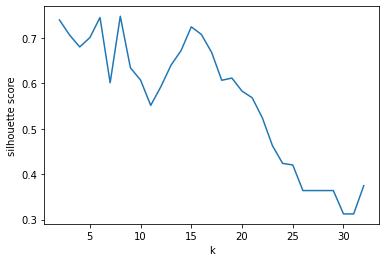

In [16]:
%matplotlib inline
from matplotlib import pyplot

pyplot.plot(kvals, silhouettes)
pyplot.xlabel('k')
pyplot.ylabel('silhouette score')
pyplot.show()

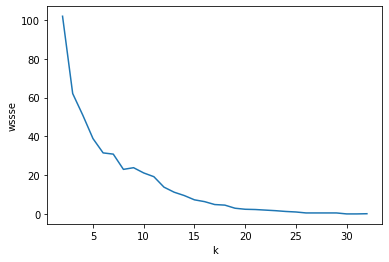

In [17]:
pyplot.plot(kvals, wssses)
pyplot.xlabel('k')
pyplot.ylabel('wssse')
pyplot.show()